# Experiment 1.1.2

In [Experiment 1.1](experiment-1.1.ipynb), I gave ChatGPT a length of inpatient stay, plus some other patient characteristics, and asked it to generate a likely presenting condition and an admission note. I deployed a second agent to critique the reasoning of the first

One thing I noticed from the output is that surgery is rarely mentioned as a concrete plan. In the [output](../src/data_exports/experiment_1.1_20231008_2106.json) from that experiment there are few mentions of consulting surgical colleagues. In comparison, in the [notebook](explore-nhse-ae-data.ipynb) analysing the original A&E synthetic dataset, it is clear that some patients are admitted for surgery. Possibly, this could be the wording I used in the prompt, which asked for 'medical condition'. That might lead the chatbot to give medical diagnoses over surgical. 

There are also other variables that could be given to ChatGPT to attempt to generate an admission note that aligns with the information given in the dataset. 

Therefore, here I modify the prompts to include these variables.

However, the performance of GPT3.5 in returning admission notes seemed much worse with the extra information, so I reverted experiment 1.1.1 to the shorter prompt. 

I'm now running the same prompts with GPT4. GPT4 did better at returning structured output in the format I wanted, but (as the charts at the end show) limited by the short prompts. 


## Set up

In [2]:
notebook_name = 'experiment_1.1.2'



In [3]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [4]:
# Load libraries
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Import the variables that have been set in the init.py folder in the root directory
# These include a constant called PROJECT_ROOT which stores the absolute path to this folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import init
PROJECT_ROOT = os.getenv("PROJECT_ROOT")

# Add the src folder to sys path, so that the application knows to look there for libraries
sys.path.append(str(Path(PROJECT_ROOT) / 'src'))

# Import function to load data
from data_ingestion.load_data import load_nhse_data

from utils.write_to_json import write_to_json
from utils.load_from_json import load_from_json

from functions.patient_class import Patient

from functions.verify_admission_decision import verify_admission_decision




## Load data

Here the function called load_file()  

* check if the NHS England datset has already been saved in a local folder called data_store in a parquet format; if so the function returns it
* if not, it checks for the zip file from the NHSE website and if not downloads it, unzips it and saves it 
* the file is unzipped to csv and read as as pandas dataframe and saved to parquet format

In [5]:
ed = load_nhse_data(admitted_only=True)
# ed.head()

## Generate 100 instances of a patient with admission notes

Here I pick rows from the A&E dataset at random, and generate admission notes for them. I chose to save these to a json file, rather than to individual text files or to SQL, as this is human readable. You can view the full output [here](../src/data_exports/note_dict_20231002_2120.json)

This uses a class definition called Patient(). To see the script, go to [../src/functions/patient_class.py](../src/functions/patient_class.py) An instance of this class, here referred to as a persona, is a single patient. The instance is populated with the variables retrieved from a single row of the ED dataset loaded above.

The steps are the following:
* select a row from the A&E data
* pass the row information to the class definition

In addition, as part of creating the persona, a call to ChatGPT is made using the OpenAI API. Certain details about the patient (listed below) are embedded into the prompt to be passed in. ChatGPT is asked to generate a medical condition, and an admission note. 

A sub-function [pick_medical_condition()](../src/functions/pick_medical_condition.py) is called to populate three additional attributes of the persona: the diagnosis, their admission note, and their most recent note (which is this case is the admission note, but later this attribute could be something else like a progress note). 

The script [pick_medical_condition()](../src/functions/pick_medical_condition.py)

* calls a function [generate_prompt_presenting_condition()](../src/functions/pick_medical_condition.py) (scroll down the file) which populates a ChatGPT prompt with details about the patient. The prompt contains ChatGPT's instructions and requests the ouput in a json format. To see the text of the prompt, go to [pick_medical_condition.txt](../templates/prompt_templates/pick_medical_condition.txt)
* calls ChatGPT with the prompt. Functions used to call ChatGPT are in [prompt_functions.py](../src/functions/prompt_functions.py)
* attempts to parse the json output

In [6]:
attributes = ['Age_Band', 'AE_Arrive_HourOfDay', 'AE_Time_Mins',  'Length_Of_Stay_Days', 'Title', 
                'Sex', 'IMD_Decile_From_LSOA', 'AE_Num_Diagnoses',
                'AE_Num_Investigations', 'AE_Num_Treatments', 
                'Treatment_Function_Title',
                'Medical_Condition', 'Admission_Note']
note_dict = {}

def row_to_patient(row):
    return Patient(*row)

import numpy as np
np.random.seed(42) 


In [7]:
while len(note_dict.keys()) < 100:

    for index, persona in ed[(~ed.Treatment_Function_Title.isnull()) & 
                             (ed.AE_Num_Diagnoses > 0)].sample(1).iterrows():

        Pat = row_to_patient(persona)

        if Pat.Admission_Note != '' and 'failed on json' not in str(Pat.Admission_Note):

            print("Successful admission note for patient with id " + str(index))
            
            note_dict[Pat.id] = {}
            note_dict[Pat.id] = {attr: getattr(Pat, attr) for attr in attributes if hasattr(Pat, attr)}

        else: 

            print("Failed admission note for patient with id " + str(index))

    if len(note_dict.keys()) % 10 == 0:
        write_to_json(note_dict, notebook_name)

write_to_json(note_dict, notebook_name)

Failed admission note for patient with id 2232899
Successful admission note for patient with id 5090916
Successful admission note for patient with id 3902443
Successful admission note for patient with id 2901784
Failed admission note for patient with id 498470
Failed admission note for patient with id 4059307
Successful admission note for patient with id 232503
Failed admission note for patient with id 4500844
Successful admission note for patient with id 2287789
Failed admission note for patient with id 517263
Successful admission note for patient with id 2013720
Successful admission note for patient with id 3043535
Successful admission note for patient with id 2611798
Failed admission note for patient with id 1719745
Successful admission note for patient with id 1555843
Successful admission note for patient with id 5068933
Successful admission note for patient with id 1874059
Successful admission note for patient with id 3159158
Failed admission note for patient with id 3758077
Succe

## Evaluate output

In [5]:
note_dict = load_from_json(notebook_name)

data = [{'id': id, **persona} for id, persona in note_dict.items()]
output = pd.DataFrame(data)

In [6]:


output['Medical_Condition'] = output['Medical_Condition'].str.lower().str.capitalize()

# Dictionary to map similar terms
similar_terms = {
    'Fractured hip': 'Hip fracture',
    'Fracture of hip': 'Hip fracture',
    'Fractured wrist': 'Fracture of the wrist',
    'Gastroesophageal reflux disease (gerd)': 'Gastroesophageal reflux disease',
    'Gastric ulcer': 'Peptic ulcer disease',
    'Kidney stones': 'Kidney stone',
    'Myocardial infarction': 'Heart attack'
}

# Replace similar terms in the array
data = [similar_terms.get(term, term) for term in output['Medical_Condition']]

# Convert the array back to a Pandas Series
output['Medical_Condition_adj'] = pd.Series(data)



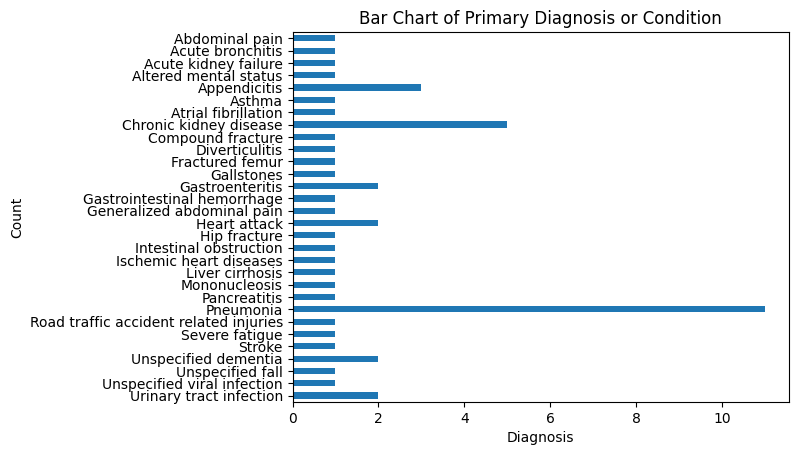

In [26]:
import matplotlib.pyplot as plt



output['Medical_Condition_adj'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Bar Chart of Primary Diagnosis or Condition')
plt.show()

### Use LLM for evaluation

In [Experiment 1.0](experiment-1.0.ipynb) I found that the agent wanted to admit people with conditions that did not merit admission. Here I use the agent first tried in [Experiment 1.0.1](experiment-1.0.1.ipynb) to evaluate the admission decision. The text prompt is [verify_admission_decision.txt](../templates/prompt_templates/verify_admission_decision.txt). The agent is given the admission note, and asked to act as a senior colleague to appraise a junior colleague's decision to admit the patient. The agent returns an agree/disagree decision, and a discharge note. (The reason for adding the discharge note was to encourage the LLM to think about how the patient's condition could be managed without admission)

The code below loops through the 100 admission notes, to evaluate whether an admission decision was the right call. An example is below.

In [42]:
opinion, reason, discharge_note = verify_admission_decision(persona['Admission_Note'])
print(f"Admission note:\n{persona['Admission_Note'].strip()}\n")
print(f"Senior colleague's opinion:\n{opinion}\n")
print(f"Reason:\n{reason}\n")
print(f"Discharge Note:\n{discharge_note}\n")

Admission note:
Chief Complaint:
The patient presented to the Accident & Emergency Department with severe abdominal pain and nausea. 

History of Present Illness:
The patient reports experiencing intermittent upper abdominal pain for the past week. The pain is typically provoked by fatty meals and radiates towards the right shoulder. The patient noticed yellowing of the skin and eyes, along with dark-colored urine. There are no associated fevers, chills, or changes in bowel habits. 

Past Medical History:
The patient has a history of obesity, but there are no previous gastrointestinal issues. There is no known family history of gallbladder disease. 

Physical Examination:
Upon examination, the patient appears uncomfortable and pale. Vital signs reveal a mildly elevated temperature of 37.5°C, heart rate of 90 bpm, blood pressure of 130/80 mmHg, and respiratory rate of 18 breaths per minute. Abdominal examination reveals tenderness in the right upper quadrant with guarding. Murphy's sign

In [6]:
agree_count = 0
failed_count = 0
opinion_list = []

for id, persona in note_dict.items():
    opinion, reason, discharge_note = verify_admission_decision(persona['Admission_Note']) 
    opinion_list.append(opinion)

    print(opinion)
    if opinion in ['agree', 'disagree']:
        note_dict[id]['Admission_Note_agreement'] = opinion
        note_dict[id]['Admission_Note_agreement_reason'] = reason
        note_dict[id]['Admission_Note_if_discharged'] = discharge_note

        if opinion == 'agree':
            agree_count += 1
    else: 
        failed_count += 1

# Add the 'opinion' values to the existing DataFrame
output['opinion'] = opinion_list

print("Number of records where senior colleague agrees: " + str(agree_count))
print("Number of records where agent evaluation failed: " + str(failed_count))



agree
agree
agree
disagree
agree
agree
disagree
agree
disagree
agree
agree
agree
agree
agree
disagree
disagree
agree
disagree
disagree
agree
agree
disagree
disagree
disagree
disagree
disagree
disagree
agree
disagree
disagree
disagree
agree
disagree
agree
agree
agree
agree
disagree
agree
agree
agree
disagree
agree
agree
agree
disagree
disagree
disagree
agree
disagree
Number of records where senior colleague agrees: 27
Number of records where agent evaluation failed: 0


In [8]:
write_to_json(note_dict, notebook_name)

### Plots for evaluation

With GPT4, the second agent appears to have ruled out admission for a number of the diagnoses that one would expect eg asthma, UTI, dementia and fatigue.

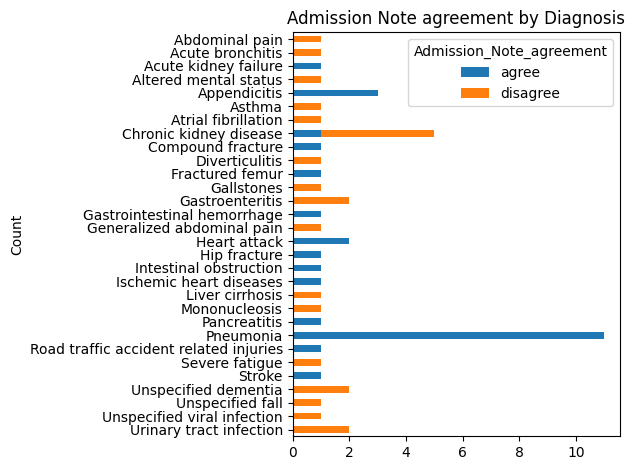

In [28]:
def plot_stacked_chart(output, variable_):
    
    df_stacked = output[output.Admission_Note_agreement != 'failed on json argument'].pivot_table(index='Medical_Condition_adj', 
                                columns=variable_ , 
                                aggfunc='size',
                                fill_value=0)

    ax = df_stacked[::-1].plot(kind='barh', stacked=True)

    ax.set_title(variable_.replace('_', ' ') + ' by Diagnosis')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_stacked_chart(output, 'Admission_Note_agreement')


The high prevalance of pneumonia seems unlikely. I was curious to see if this is a default choice by age band

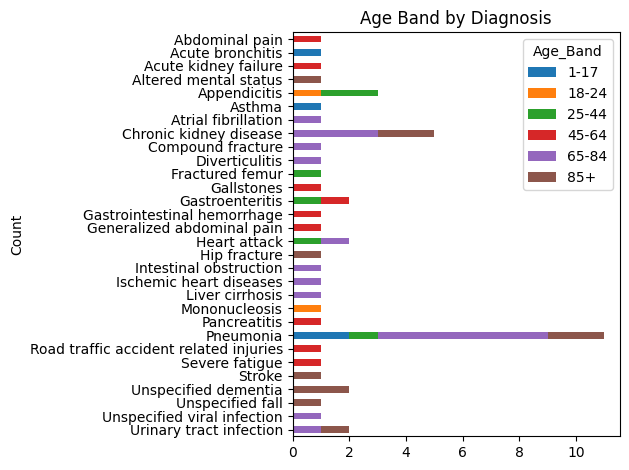

In [29]:
plot_stacked_chart(output, 'Age_Band')

Looking at whether surgical admissions (according to the original dataset) have been routed toward surgical treatments. It seems unlikely that gastroenteritis, mononucleosis or liver cirrhosis woud require immediate surgery. 

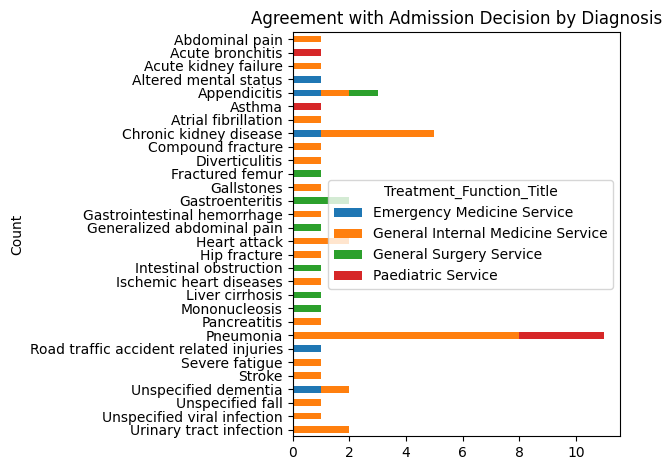

In [22]:
# output.head().T
plot_stacked_chart(output, 'Treatment_Function_Title')